# Litteraturbanken Author 
version 1.20 -  added link json 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * video Swedish
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

#### Other sources we sync
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2020-12-04 09:01:00.519864


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,dramawebben,popularity,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
379,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1606822936924,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,"{'birthplace': [9.1775, 48.776111111], 'birthp...",NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 0 to 3856
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 3857 non-null   object        
 1   wd_hos_Litteraturbanken  1552 non-null   object        
 2   authorid_norm            3857 non-null   object        
 3   show                     3857 non-null   bool          
 4   updated                  3193 non-null   datetime64[ns]
 5   imported                 3193 non-null   datetime64[ns]
 6   librisid                 2061 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 184.7+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     2317
False    1540
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 1 to 3856
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2317 non-null   object        
 1   wd_hos_Litteraturbanken  1529 non-null   object        
 2   authorid_norm            2317 non-null   object        
 3   show                     2317 non-null   bool          
 4   updated                  1869 non-null   datetime64[ns]
 5   imported                 1869 non-null   datetime64[ns]
 6   librisid                 1232 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 129.0+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:10]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,SöderhjelmA,NaN,SoderhjelmA,True,2020-11-30,2020-11-30,64jlpl7q4kwsp33
1,EklundM,NaN,EklundM,True,2020-11-30,2020-11-30,NaN
2,NilssonTO,NaN,NilssonTO,True,2020-11-30,2020-11-30,97mprgdt4lcdh9n
3,JohannessonPJ,NaN,JohannessonPJ,True,2020-11-30,2020-11-13,NaN
4,HaquinusBenedicti,NaN,HaquinusBenedicti,True,2020-11-30,2020-11-30,wt79c7tf4fh06x5
5,RennerM,NaN,RennerM,True,2020-11-30,2020-11-30,xv8bd07g1bq4jb9
6,SörmanP,NaN,SormanP,True,2020-11-30,2020-11-30,NaN
7,FalkEJ,NaN,FalkEJ,True,2020-11-30,2020-11-30,0xbdgx6j4tjtr7t
8,CollingLJ,NaN,CollingLJ,True,2020-11-30,2020-11-30,wt7bgt1f0z7tr34
9,BromanG,NaN,BromanG,True,2020-11-13,2020-11-13,NaN


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:30]

,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,SöderhjelmA,NaN,SoderhjelmA,True,2020-11-30,2020-11-30,64jlpl7q4kwsp33
1,NilssonTO,NaN,NilssonTO,True,2020-11-30,2020-11-30,97mprgdt4lcdh9n
2,EklundM,NaN,EklundM,True,2020-11-30,2020-11-30,NaN
3,HaquinusBenedicti,NaN,HaquinusBenedicti,True,2020-11-30,2020-11-30,wt79c7tf4fh06x5
4,RennerM,NaN,RennerM,True,2020-11-30,2020-11-30,xv8bd07g1bq4jb9
5,SörmanP,NaN,SormanP,True,2020-11-30,2020-11-30,NaN
6,FalkEJ,NaN,FalkEJ,True,2020-11-30,2020-11-30,0xbdgx6j4tjtr7t
7,CollingLJ,NaN,CollingLJ,True,2020-11-30,2020-11-30,wt7bgt1f0z7tr34
8,StålhaneA,NaN,StalhaneA,True,2020-11-13,2020-11-13,NaN
9,HagbergL,NaN,HagbergL,True,2020-11-13,2020-11-13,NaN


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  1900 non-null   object
 1   authorid    1900 non-null   object
dtypes: object(2)
memory usage: 29.8+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    6
authorid      6
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("LilljegrenJ")]

,WikidataID,authorid
1063,Q99964978,LilljegrenJ


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
1904,NaN,JohannessonPJ,NaN,JohannessonPJ,True,2020-11-30,2020-11-13,NaN,Litterturbanken_only
1687,Q436480,SöderhjelmA,NaN,SoderhjelmA,True,2020-11-30,2020-11-30,64jlpl7q4kwsp33,both
1424,Q103728266,RennerM,NaN,RennerM,True,2020-11-30,2020-11-30,xv8bd07g1bq4jb9,both
553,Q103729396,FalkEJ,NaN,FalkEJ,True,2020-11-30,2020-11-30,0xbdgx6j4tjtr7t,both
740,Q103724982,HaquinusBenedicti,NaN,HaquinusBenedicti,True,2020-11-30,2020-11-30,wt79c7tf4fh06x5,both
1901,NaN,SörmanP,NaN,SormanP,True,2020-11-30,2020-11-30,NaN,Litterturbanken_only
1900,NaN,EklundM,NaN,EklundM,True,2020-11-30,2020-11-30,NaN,Litterturbanken_only
1268,Q24006037,NilssonTO,NaN,NilssonTO,True,2020-11-30,2020-11-30,97mprgdt4lcdh9n,both
387,Q5610936,CollingLJ,NaN,CollingLJ,True,2020-11-30,2020-11-30,wt7bgt1f0z7tr34,both
1791,Q6231238,WallinS,NaN,WallinS,True,2020-11-13,2020-11-13,NaN,both


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2343 entries, 1904 to 2342
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1900 non-null   object        
 1   authorid                 2343 non-null   object        
 2   wd_hos_Litteraturbanken  1529 non-null   object        
 3   authorid_norm            2317 non-null   object        
 4   show                     2317 non-null   object        
 5   updated                  1869 non-null   datetime64[ns]
 6   imported                 1869 non-null   datetime64[ns]
 7   librisid                 1232 non-null   object        
 8   WD_Litteraturbanken      2343 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 183.0+ KB


### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [19]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1874
Litterturbanken_only     443
WD_only                   26
Name: WD_Litteraturbanken, dtype: int64

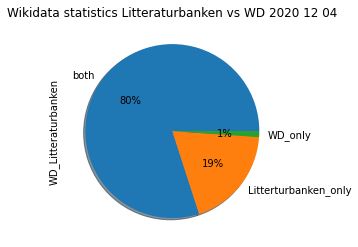

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [21]:
mergeCheckNumber

both                    1874
Litterturbanken_only     443
WD_only                   26
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [22]:
#mergewithLibris

In [23]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [24]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 1687 to 1428
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1231 non-null   object        
 1   authorid                 1232 non-null   object        
 2   wd_hos_Litteraturbanken  1001 non-null   object        
 3   authorid_norm            1232 non-null   object        
 4   show                     1232 non-null   object        
 5   updated                  1232 non-null   datetime64[ns]
 6   imported                 1232 non-null   datetime64[ns]
 7   librisid                 1232 non-null   object        
 8   WD_Litteraturbanken      1232 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 96.2+ KB


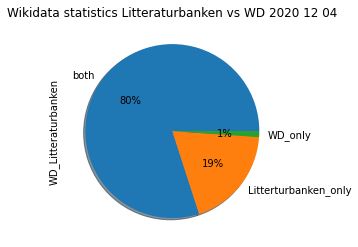

In [25]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [26]:
mergeCheckNumber

both                    1874
Litterturbanken_only     443
WD_only                   26
Name: WD_Litteraturbanken, dtype: int64

In [27]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 75 to 1891
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               26 non-null     object        
 1   authorid                 26 non-null     object        
 2   wd_hos_Litteraturbanken  0 non-null      object        
 3   authorid_norm            0 non-null      object        
 4   show                     0 non-null      object        
 5   updated                  0 non-null      datetime64[ns]
 6   imported                 0 non-null      datetime64[ns]
 7   librisid                 0 non-null      object        
 8   WD_Litteraturbanken      26 non-null     object        
dtypes: datetime64[ns](2), object(7)
memory usage: 2.0+ KB


In [28]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   authorid                 2317 non-null   object        
 1   wd_hos_Litteraturbanken  1529 non-null   object        
 2   authorid_norm            2317 non-null   object        
 3   show                     2317 non-null   bool          
 4   updated                  1869 non-null   datetime64[ns]
 5   imported                 1869 non-null   datetime64[ns]
 6   librisid                 1232 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 111.0+ KB


In [29]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 26 non-null     object        
 1   authorid_x                 26 non-null     object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        26 non-null     object        
 9   authorid_y                 2317 non-null   object        
 10  wd_hos_Litteraturbanken_y  1529 non-null   object        
 11  authorid_norm_y            2317 non-null   object        
 12  show_y

In [30]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

In [31]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [32]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 

1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [33]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,authorid_y,authorid_x,show_y,WikidataID
0,DahlénT,DahlenT,True,Q99771903
1,FjørtoftK,FjortoftK,True,Q99871759
2,HagströmT,HagstromT,True,Q100235624
3,ÖstinO,OstinO,True,Q100752816
4,StaëlvonHolsteinAL,StaelvonHolsteinAL,True,Q31872554
5,StålmarckT,StalmarckT,True,Q64220930
6,TäubelCG,TaubelCG,True,Q95794561


In [34]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

,authorid,Littbank,WikidataID
75,AndrénV,link,Q5556719
118,AustenJ,link,Q36322
175,BerggrenH,link,Q100776235
213,BirchPfeifferC,link,Q68117
229,BjörkmanE,link,Q11859217
324,ButenschönA,link,Q14932468
412,DahlenT,link,Q99771903
441,DobbinL,link,Q100414371
568,FjortoftK,link,Q99871759
722,HagstromT,link,Q100235624


In [35]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [36]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 7 non-null      object        
 1   authorid_x                 7 non-null      object        
 2   wd_hos_Litteraturbanken_x  0 non-null      object        
 3   authorid_norm_x            0 non-null      object        
 4   show_x                     0 non-null      object        
 5   updated_x                  0 non-null      datetime64[ns]
 6   imported_x                 0 non-null      datetime64[ns]
 7   librisid_x                 0 non-null      object        
 8   WD_Litteraturbanken        7 non-null      object        
 9   Littbank                   7 non-null      object        
 10  authorid_y                 7 non-null      object        
 11  wd_hos_Litteraturbanken_y  7 non-null      object        
 12  authorid_nor

In [37]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q99771903,DahlenT,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,DahlénT,Q99771903,DahlenT,True,2018-01-18,2018-01-18,NaN,both
1,Q99871759,FjortoftK,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,FjørtoftK,Q99871759,FjortoftK,True,2014-03-14,2014-03-14,NaN,both
2,Q100235624,HagstromT,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,HagströmT,Q100235624,HagstromT,True,2014-01-20,2014-01-20,NaN,both
3,Q100752816,OstinO,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,ÖstinO,Q100752816,OstinO,True,NaT,NaT,NaN,both
4,Q31872554,StaelvonHolsteinAL,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,StaëlvonHolsteinAL,Q31872554,StaelvonHolsteinAL,True,NaT,NaT,NaN,both


In [38]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [39]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    1874
Litterturbanken_only     443
WD_only                   26
Name: WD_Litteraturbanken, dtype: int64

In [40]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443 entries, 1904 to 2342
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 443 non-null    object        
 2   wd_hos_Litteraturbanken  12 non-null     object        
 3   authorid_norm            443 non-null    object        
 4   show                     443 non-null    object        
 5   updated                  198 non-null    datetime64[ns]
 6   imported                 198 non-null    datetime64[ns]
 7   librisid                 1 non-null      object        
 8   WD_Litteraturbanken      443 non-null    object        
dtypes: datetime64[ns](2), object(7)
memory usage: 34.6+ KB


In [41]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                 0
authorid                   1
wd_hos_Litteraturbanken    0
authorid_norm              1
show                       1
updated                    1
imported                   1
librisid                   1
WD_Litteraturbanken        1
dtype: int64

## Errors funna nedan 
* Show True borde det inte vara False?: Eugénie BerglindhU EngeströmL Rafael WestinF 
* Dublett: NordinCG / NordinC , ArfvidssonN / ArfwidssonN 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [42]:
#Litterturbanken_only.head()

In [43]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy() 
Litterturbanken_onlyW["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
HTML(Litterturbanken_onlyW.to_html(escape=False))


,WD_Litteraturbanken,WikidataID,librisid,authorid,show,Littbank,LittbankJSON
2050,Litterturbanken_only,NaN,hftwzq01397wbbd,ArfvidssonN,True,link Litteraturbanken,json


In [44]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [45]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [46]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [47]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     1884
right_only    1524
both            16
Name: _merge, dtype: int64

In [48]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata
75,Q5556719,AndrénV,NaN,AndrenV,False,2019-10-16,2014-02-11,31fhkwkm15ph5nn,link Litteraturbanken,json,WD
118,Q36322,AustenJ,Q36322,AustenJ,False,2019-10-16,2014-02-11,gdsvwng02fdsq4t,link Litteraturbanken,json,WD
175,Q100776235,BerggrenH,Q100776235,BerggrenH,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
213,Q68117,BirchPfeifferC,Q68117,BirchPfeifferC,False,2019-05-14,2018-10-25,NaN,link Litteraturbanken,json,WD
229,Q11859217,BjörkmanE,NaN,BjorkmanE,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
324,Q14932468,ButenschönA,NaN,ButenschonA,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
441,Q100414371,DobbinL,Q100414371,DobbinL,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
724,Q4003029,HallbergP,Q4003029,HallbergP,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
900,Q19794071,JonssonErnst,Q19794071,JonssonErnst,False,2018-10-25,2018-10-25,NaN,link Litteraturbanken,json,WD
1138,Q4964260,LundströmM,NaN,LundstromM,False,2020-06-25,2018-10-25,NaN,link Litteraturbanken,json,WD


In [49]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 75 to 1891
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               16 non-null     object        
 1   authorid                 16 non-null     object        
 2   wd_hos_Litteraturbanken  7 non-null      object        
 3   authorid_norm            16 non-null     object        
 4   show                     16 non-null     object        
 5   updated                  15 non-null     datetime64[ns]
 6   imported                 15 non-null     datetime64[ns]
 7   librisid                 4 non-null      object        
 8   Littbank                 16 non-null     object        
 9   LittbankJSON             16 non-null     object        
 10  Wikidata                 16 non-null     object        
dtypes: datetime64[ns](2), object(9)
memory usage: 1.5+ KB


In [50]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','ButenschönA','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','AndrénV','DobbinL','HallbergP','JonssonErnst',
                                    'WästbergA','LundströmM','WästbergA','NordlingS','BerggrenH','AustenJ'
                                             
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))

## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

**Lessom learned** we have bots that update from Litteraturbanken that sometimes add a mess....

In [54]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge


In [52]:
# Indicates that trhis memeber shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge


In [53]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

Ended:  2020-12-04 09:01:07.701760
Time elapsed (hh:mm:ass.ms) 0:00:07.183187
